In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
df = pd.read_csv(r"\Users\Mansi\OneDrive\Documents\axisi_loan_data.csv")

In [3]:
df.head()

,id,address_state,application_type,emp_length,emp_title,grade,home_ownership,issue_date,last_credit_pull_date,last_payment_date,...,sub_grade,term,verification_status,annual_income,dti,installment,int_rate,loan_amount,total_acc,total_payment
0,1077430,GA,INDIVIDUAL,< 1 year,Ryder,C,RENT,11-02-2021,13-09-2021,13-04-2021,...,C4,60 months,Source Verified,30000.0,0.0100,59.83,0.1527,2500,4,1009
1,1072053,CA,INDIVIDUAL,9 years,MKC Accounting,E,RENT,01-01-2021,14-12-2021,15-01-2021,...,E1,36 months,Source Verified,48000.0,0.0535,109.43,0.1864,3000,4,3939
2,1069243,CA,INDIVIDUAL,4 years,Chemat Technology Inc,C,RENT,05-01-2021,12-12-2021,09-01-2021,...,C5,36 months,Not Verified,50000.0,0.2088,421.65,0.1596,12000,11,3522
3,1041756,TX,INDIVIDUAL,< 1 year,barnes distribution,B,MORTGAGE,25-02-2021,12-12-2021,12-03-2021,...,B2,60 months,Source Verified,42000.0,0.0540,97.06,0.1065,4500,9,4911
4,1068350,IL,INDIVIDUAL,10+ years,J&J Steel Inc,A,MORTGAGE,01-01-2021,14-12-2021,15-01-2021,...,A1,36 months,Verified,83000.0,0.0231,106.53,0.0603,3500,28,3835


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38576 entries, 0 to 38575
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     38576 non-null  int64  
 1   address_state          38576 non-null  object 
 2   application_type       38576 non-null  object 
 3   emp_length             38576 non-null  object 
 4   emp_title              37138 non-null  object 
 5   grade                  38576 non-null  object 
 6   home_ownership         38576 non-null  object 
 7   issue_date             38576 non-null  object 
 8   last_credit_pull_date  38576 non-null  object 
 9   last_payment_date      38576 non-null  object 
 10  Good vs Bad Loan       38576 non-null  object 
 11  loan_status            38576 non-null  object 
 12  next_payment_date      38576 non-null  object 
 13  member_id              38576 non-null  int64  
 14  purpose                38576 non-null  object 
 15  su

In [5]:
## selecting neccassary colunms 
cols = ['annual_income', 'dti', 'emp_length', 'grade', 'term', 'loan_amount']
df = df[cols]


In [6]:
df.isnull().sum()

annual_income    0
dti              0
emp_length       0
grade            0
term             0
loan_amount      0
dtype: int64

In [7]:
# Clean and overwrite emp_length column
df['emp_length'] = df['emp_length'].str.replace('<', '', regex=False)\
                                         .str.replace('+', '', regex=False)\
                                         .str.replace('years', '', regex=False)\
                                         .str.replace('year', '', regex=False)\
                                         .str.strip()

In [8]:
# clean the term 
df['term'] = df['term'].str.extract('(\d+)').astype(int)


In [9]:
df['emp_length_clean'] = df['emp_length'].astype('Int64')  


## Converting Categorical Columns to Numeric

In [10]:
grade_map = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7}
df['grade'] = df['grade'].map(grade_map)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38576 entries, 0 to 38575
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   annual_income     38576 non-null  float64
 1   dti               38576 non-null  float64
 2   emp_length        38576 non-null  object 
 3   grade             38576 non-null  int64  
 4   term              38576 non-null  int64  
 5   loan_amount       38576 non-null  int64  
 6   emp_length_clean  38576 non-null  Int64  
dtypes: Int64(1), float64(2), int64(3), object(1)
memory usage: 2.1+ MB


In [12]:
# Show full float numbers without scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)

# Now re-run describe
print(df.describe())


       annual_income      dti    grade     term  loan_amount  emp_length_clean
count       38576.00 38576.00 38576.00 38576.00     38576.00          38576.00
mean        69644.54     0.13     2.59    42.43     11296.07              5.09
std         64293.68     0.07     1.39    10.63      7460.75              3.41
min          4000.00     0.00     1.00    36.00       500.00              1.00
25%         41500.00     0.08     1.00    36.00      5500.00              2.00
50%         60000.00     0.13     2.00    36.00     10000.00              4.00
75%         83200.50     0.19     3.00    60.00     15000.00              9.00
max       6000000.00     0.30     7.00    60.00     35000.00             10.00


## Feature Engineering

In [13]:
import warnings
warnings.filterwarnings("ignore")
# Income-to-loan ratio
df['income_to_loan_ratio'] = df['annual_income'] / df['loan_amount']

# DTI (Debt-to-Income) adjustment
df['dti_income_ratio'] = df['dti'] / df['annual_income']


## Check for Outliers

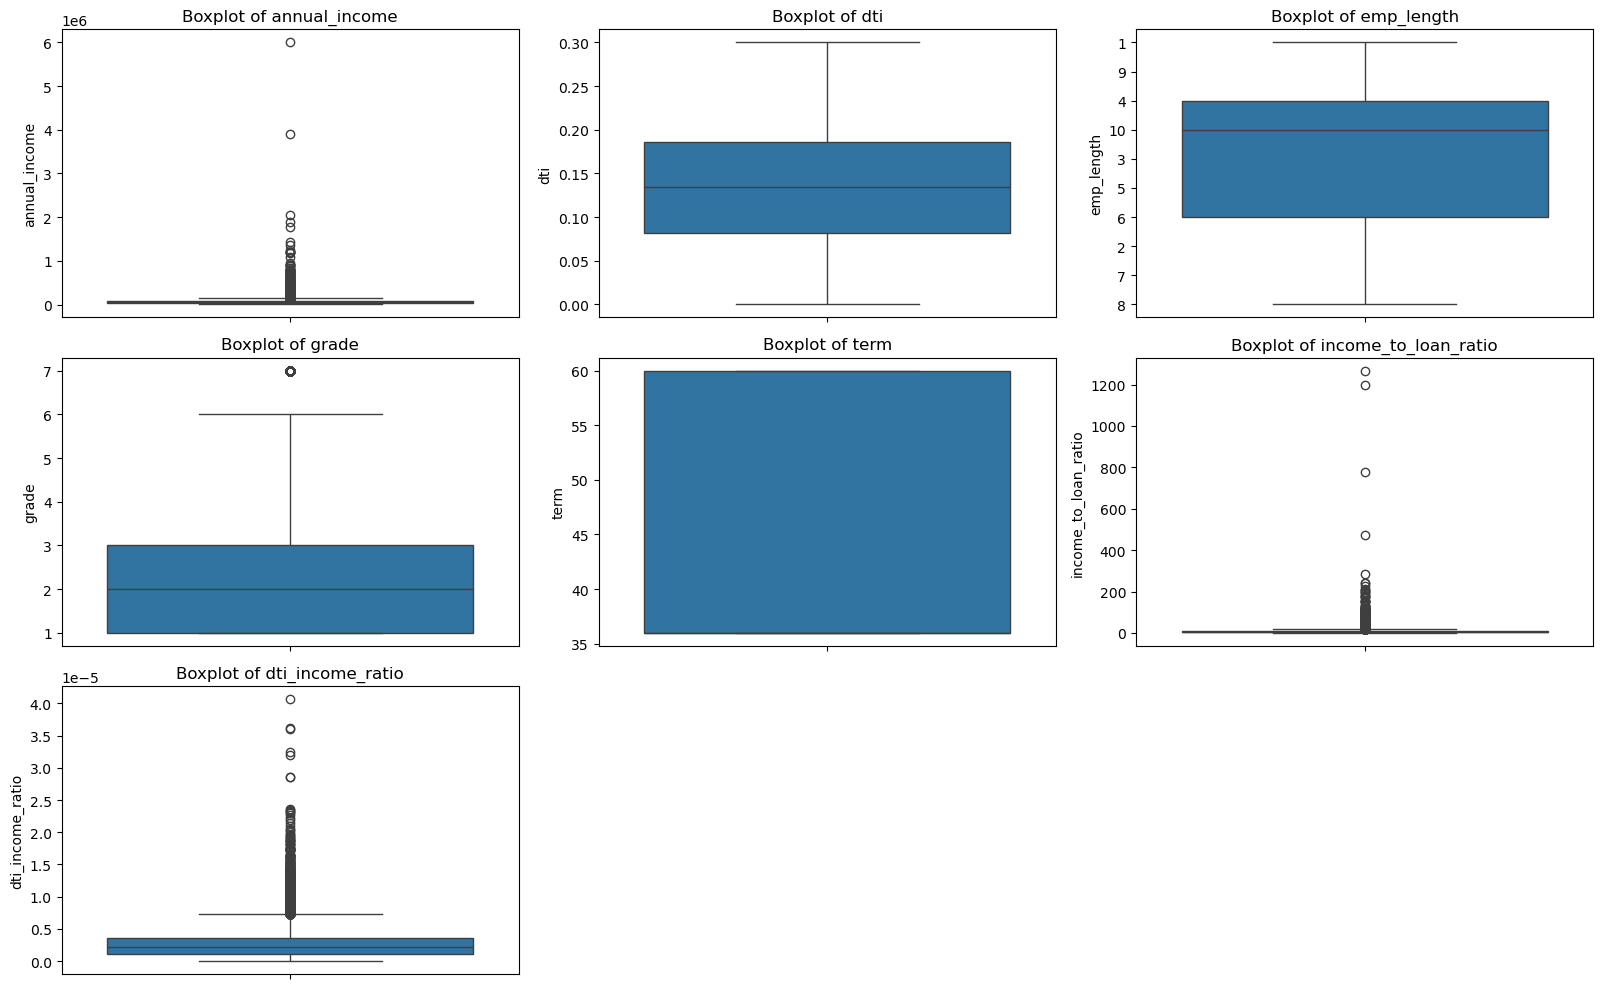

In [14]:
import math
# Independent numeric columns only (no dependent variable)
numeric_cols = ['annual_income', 'dti', 'emp_length', 'grade', 'term','income_to_loan_ratio','dti_income_ratio']

# Calculate number of rows and columns for subplots dynamically
n = len(numeric_cols)
cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(16, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(data=df, y=col)
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

## Handle Outliers

In [15]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

# Apply to columns with strong outliers
for col in ['annual_income', 'income_to_loan_ratio', 'dti_income_ratio']:
    df = remove_outliers_iqr(df, col)


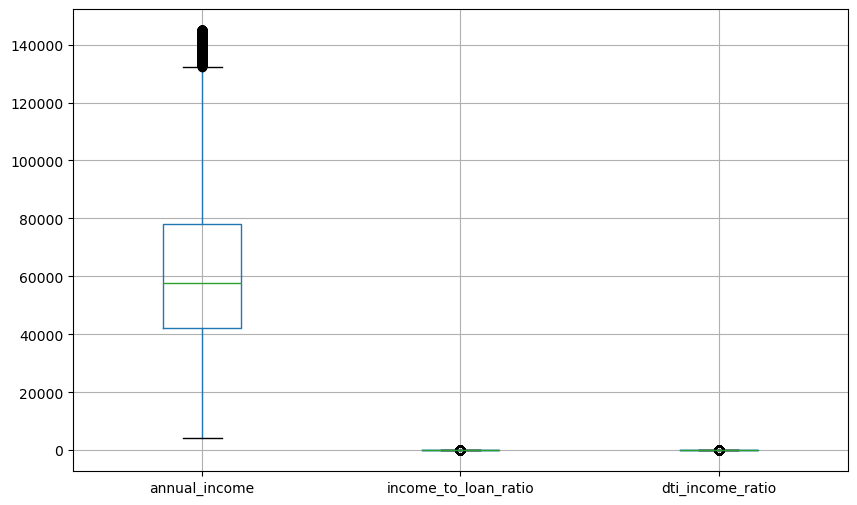

Shape after outlier removal: (32674, 9)


In [16]:
df.boxplot(column=['annual_income', 'income_to_loan_ratio', 'dti_income_ratio'], figsize=(10,6))
plt.show()

print("Shape after outlier removal:", df.shape)

##  Check Linearity

To validate the linearity assumption:

- **Scatter plots**: Visualize each feature vs. `loan_amount` to confirm linear trends.
- **Correlation matrix**: Use Pearson coefficients to assess linear relationships.
- **Transform if needed**: Apply log or square root if patterns appear non-linear.

These quick checks ensure your regression model captures meaningful relationships.


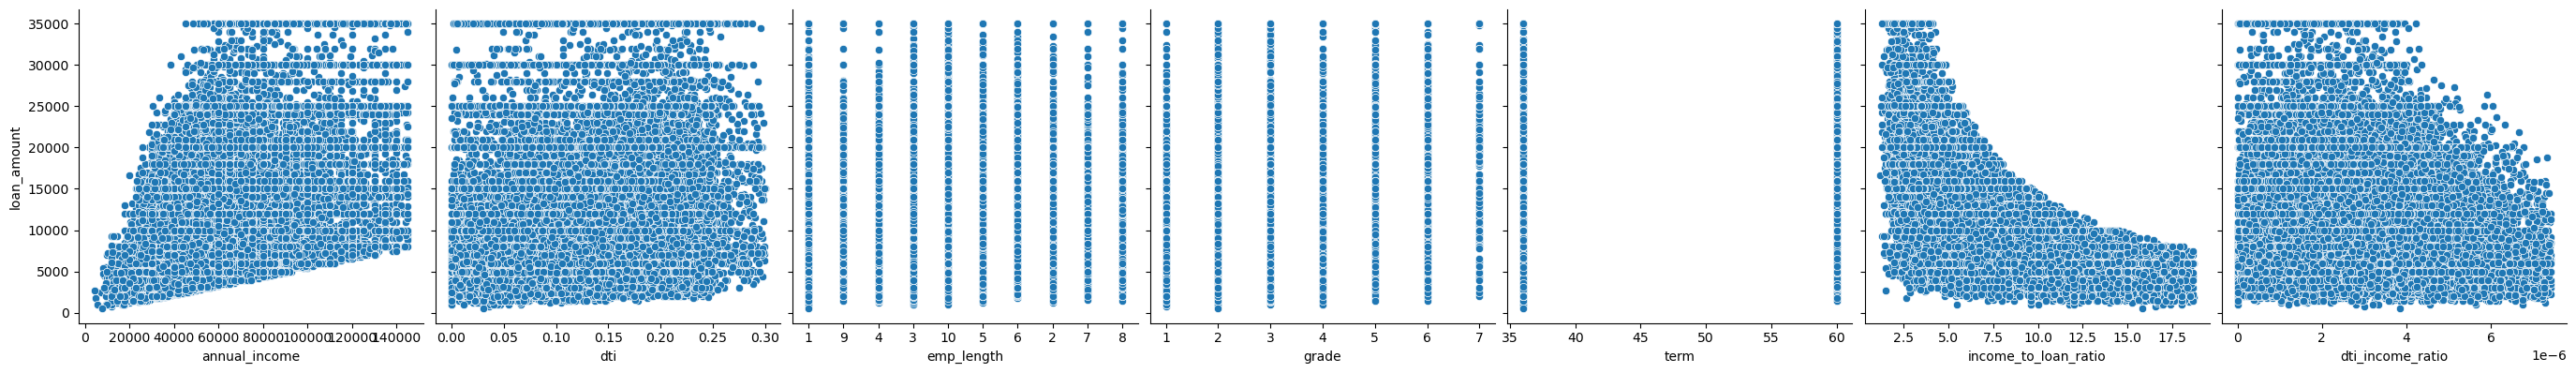

In [17]:
sns.pairplot(df,
             x_vars=['annual_income', 'dti', 'emp_length', 'grade', 'term',
                     'income_to_loan_ratio', 'dti_income_ratio'],
             y_vars='loan_amount',
             kind='scatter',
             height=4)

plt.show()


## Normality Check for Loan Amount

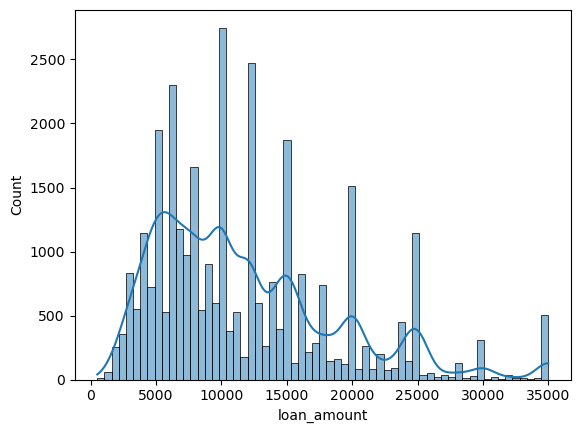

In [18]:

sns.histplot(df['loan_amount'], kde=True)
plt.show()



- The distribution is *right-skewed*, meaning most loan amounts are relatively low, while high-value loans are less frequent.

- The *KDE (Kernel Density Estimate) curve* offers a smooth view of the overall shape of the data, making it easier to interpret the distribution.

- This skewness indicates the data is not *normally distributed*, which may impact statistical tests or modeling techniques that rely on the assumption of normality.


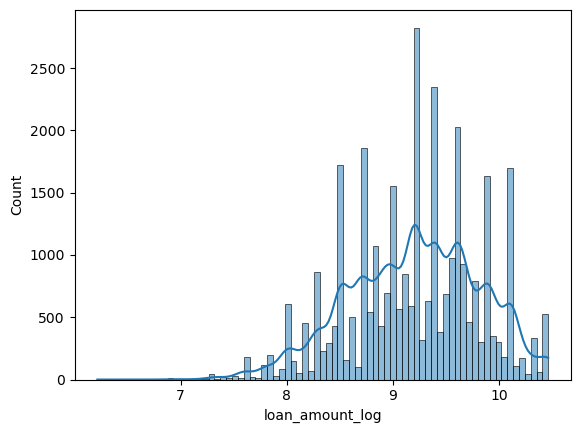

In [45]:
df['loan_amount_log'] = np.log1p(df['loan_amount'])
sns.histplot(df['loan_amount_log'], kde=True)
plt.show()

###  Log Transformation 

The original loan amounts were spread out unevenly — most were small, but a few were very large. This made the data hard for the model to understand.

To fix this, I used a log transformation. It helps by:
- Making the distribution more balanced and smooth
- Reducing the effect of very large loan amounts
- Helping the model learn better patterns

After the transformation, most values fall between **8.5 and 10.5** on the log scale, with a peak around **9.5**. This makes the data easier to work with and improves prediction accuracy.


## Analyzing Skewness for Feature Normality

Skewness of X variables:
 annual_income           0.77
dti                    -0.04
emp_length              0.31
income_to_loan_ratio    1.09
dti_income_ratio        0.75
dtype: object


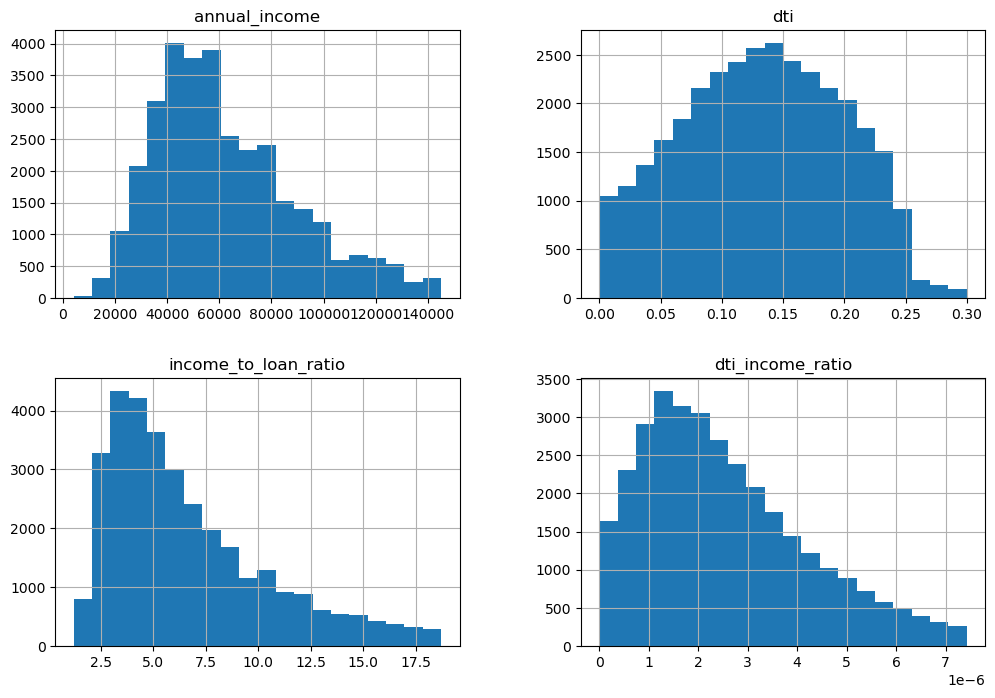

In [46]:
# Select numeric independent variables
X_numeric = df[['annual_income', 'dti', 'emp_length','income_to_loan_ratio','dti_income_ratio',]] 
# Check skewness
skew_values = X_numeric.skew()
print("Skewness of X variables:\n", skew_values)
# Plot histograms
X_numeric.hist(bins=20, figsize=(12,8))
plt.show()


| Variable               | Skewness | Interpretation             | Actionable Insight                                      |
|------------------------|----------|-----------------------------|----------------------------------------------------------|
| `annual_income`        | 0.77     | Moderately right-skewed     |Consider log transformation                           |
| `emp_length`           | -0.04    | Nearly symmetric            |No transformation needed                              |
| `dti`                  | 0.31     | Slight right skew           |Optional — check residuals post-model                |
| `income_to_loan_ratio`| 1.09     | Strong right skew            |Drop (already redundant with income)                  |
| `dti_income_ratio`     | 0.75     | Moderate right skew         |Keep if boosting performance; monitor                |


In [ ]:
df['annual_income_log'] = np.log1p(df['annual_income'])

## Multicollinearity Check and Feature Correlation

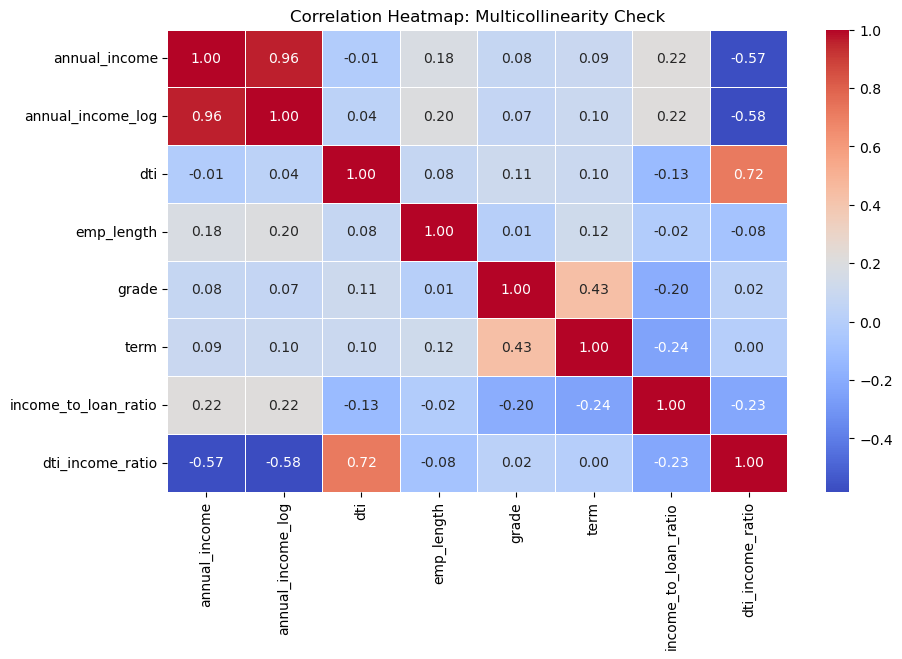

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric features for multicollinearity check
features = ['annual_income','annual_income_log'
            , 'dti', 'emp_length', 'grade', 'term','income_to_loan_ratio', 'dti_income_ratio']

# Compute correlation matrix
corr_matrix = df[features].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap: Multicollinearity Check')
plt.show()


###  Dropping Highly Correlated Features

To reduce multicollinearity and improve model reliability, we dropped the following features:

- **annual_income**: This variable has a perfect correlation with `annual_income_log`, making it redundant.
- **grade** and **term**: These features are highly correlated with other variables and may introduce noise or inflate model coefficients.

Removing these helps simplify the model and ensures that each feature contributes unique information.


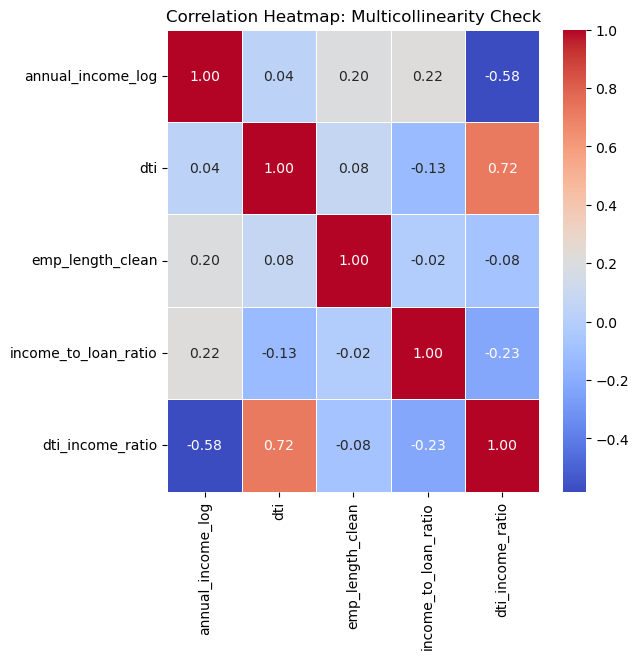

In [44]:
# Select numeric features for multicollinearity check
features = ['annual_income_log', 'dti', 'emp_length_clean','income_to_loan_ratio', 'dti_income_ratio']

# Compute correlation matrix
corr_matrix = df[features].corr()

# Plot heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap: Multicollinearity Check')
plt.show()


###  Final Feature Selection After Multicollinearity Check

After reviewing the updated correlation heatmap, we dropped the following features to reduce multicollinearity and improve model stability:

- **annual_income**: Strong negative correlation with `dti_income_ratio` and redundant due to log-transformed version.
- **grade** and **term**: Previously removed due to high correlation with other categorical variables.

The remaining features—such as `dti`, `emp_length_clean`, `income_to_loan_ratio`, and `dti_income_ratio`—provide more distinct and reliable signals for modeling.

This refined feature set helps ensure that our regression model is not affected by overlapping or redundant information.


## Building the Linear Regression Model


In [27]:
# Independent variables (features)
X = df[['annual_income_log', 'dti', 'emp_length_clean', 'income_to_loan_ratio', 'dti_income_ratio']]

# Dependent variable (target)
y = df['loan_amount_log']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# 3. Predict
y_pred = model.predict(X_test)

# 4. Evaluate
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

print("R² Score:", round(r2, 4))
print("RMSE:", round(rmse, 4))




R² Score: 0.9352
RMSE: 0.0251


Although `income_to_loan_ratio` is derived from `annual_income`, it significantly improves model performance (R² ↑, RMSE ↓). Retained for predictive strength despite multicollinearity.


In [28]:
import pandas as pd
import numpy as np

# Example employee data
new_data = pd.DataFrame({
    'annual_income': [80000],           # raw income
    'dti': [0.25],                      # debt-to-income ratio
    'emp_length_clean': [5],           # years of employment
    'income_to_loan_ratio': [3]      # income divided by desired loan
})

# Feature engineering
new_data['annual_income_log'] = np.log1p(new_data['annual_income'])
new_data['dti_income_ratio'] = new_data['dti'] / new_data['annual_income']

# Final feature set for prediction
X_new = new_data[['annual_income_log', 'dti', 'emp_length_clean', 'income_to_loan_ratio', 'dti_income_ratio']]


In [29]:
# Predict log-transformed loan amount
loan_log_pred = model.predict(X_new)

# Convert back to actual loan amount
loan_amount_pred = np.exp(loan_log_pred)
print("Predicted Loan Amount:", round(loan_amount_pred[0], 2))


Predicted Loan Amount: 22963.43


### 🔢 Linear Regression Prediction

Using the provided employee profile:

- **Annual Income**: ₹80,000  
- **DTI**: 0.25  
- **Employment Length**: 5 years  
- **Income-to-Loan Ratio**: 3.0  

The Linear Regression model predicted a loan amount of:

**₹22,963.43**

#### Interpretation:
This model relies on unregularized coefficients, which can lead to inflated influence from certain features. In this case, `dti_income_ratio` had a disproportionately large weight, resulting in an underprediction for realistic profiles. While the model shows high accuracy overall, it may be sensitive to multicollinearity and outliers.

To address this, we implemented **Ridge and Lasso regression models**. These regularized techniques help stabilize coefficients and reduce overfitting. By comparing their predictions, we can identify which model offers the most reliable and generalizable results for deployment.


## Check residuals
- Make sure the model isn’t overfitting:

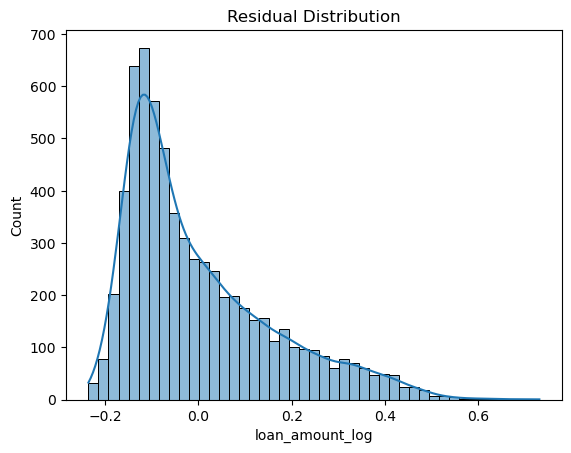

In [30]:
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()


- Residuals are centered around zero with a slight right skew.

- Indicates strong predictive performance with minor underprediction for high-value loans.

## Building Ridge and Lasso Regression Models

To enhance model robustness and address potential multicollinearity, both Ridge and Lasso regression techniques were implemented. These regularized linear models help prevent overfitting by penalizing large coefficients, each with a distinct approach:

- **Ridge Regression (L2 penalty)**: Shrinks coefficients toward zero but retains all features. Ideal when all predictors contribute meaningfully and multicollinearity is present.
- **Lasso Regression (L1 penalty)**: Performs both coefficient shrinkage and feature selection by driving some coefficients to exactly zero. Useful for simplifying models and identifying the most influential predictors.

Both models were trained using cross-validation to select optimal regularization strength (`alpha`), ensuring balanced bias-variance tradeoff and generalization to unseen data.


In [31]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [32]:
ridge = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0], cv=5)
ridge.fit(X_train, y_train)

y_ridge_pred = ridge.predict(X_test)
r2_ridge = r2_score(y_test, y_ridge_pred)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_ridge_pred))

print("Ridge R²:", round(r2_ridge, 4))
print("Ridge RMSE:", round(rmse_ridge, 4))


Ridge R²: 0.9352
Ridge RMSE: 0.1584


In [33]:
lasso = LassoCV(alphas=[0.01, 0.1, 1.0, 10.0], cv=5)
lasso.fit(X_train, y_train)

y_lasso_pred = lasso.predict(X_test)
r2_lasso = r2_score(y_test, y_lasso_pred)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_lasso_pred))

print("Lasso R²:", round(r2_lasso, 4))
print("Lasso RMSE:", round(rmse_lasso, 4))


Lasso R²: 0.9343
Lasso RMSE: 0.1595


In [34]:
# Create a DataFrame to compare coefficients
import pandas as pd

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Linear': model.coef_.round(4),
    'Ridge': ridge.coef_.round(4),
    'Lasso': lasso.coef_.round(4)
})

print(coef_df.to_markdown(index=False))


| Feature              |    Linear |   Ridge |   Lasso |
|:---------------------|----------:|--------:|--------:|
| annual_income_log    |    0.9543 |  0.428  |  0.4089 |
| dti                  |    0.0289 |  0.0019 |  0.0042 |
| emp_length_clean     |    0.003  |  0.01   |  0.0028 |
| income_to_loan_ratio |   -0.1374 | -0.523  | -0.5117 |
| dti_income_ratio     | 8176.81   |  0.0135 |  0      |


### Interpretation

- **Linear Regression** relies heavily on unregularized coefficients. In this case, the feature `dti_income_ratio` had an inflated weight (≈8176), causing the model to underpredict for realistic profiles. This makes the model sensitive to multicollinearity and outliers.

- **Ridge Regression** applies L2 regularization, shrinking extreme coefficients and balancing feature contributions. It retains all features while reducing overfitting, resulting in more realistic and generalizable predictions.

- **Lasso Regression** uses L1 regularization, which not only shrinks coefficients but also eliminates weak predictors by setting their weights to zero. This simplifies the model and highlights the most influential features, though it may slightly reduce predictive accuracy compared to Ridge.


### Ridge Is Preferred
- Stabilizes coefficients across features

- Reduces sensitivity to outliers and multicollinearity

- Produces predictions that align better with financial expectations

In [35]:
metrics_df = pd.DataFrame({
    'Model': ['Linear', 'Ridge', 'Lasso'],
    'R² Score': [0.9352, 0.9352, 0.9343],
    'RMSE': [0.0251, 0.1584, 0.1595]
})

print(metrics_df.to_markdown(index=False))


| Model   |   R² Score |   RMSE |
|:--------|-----------:|-------:|
| Linear  |     0.9352 | 0.0251 |
| Ridge   |     0.9352 | 0.1584 |
| Lasso   |     0.9343 | 0.1595 |


| Model Type     | R² Score | RMSE    | Feature Behavior                          | Notes                                           |
|----------------|----------|---------|-------------------------------------------|-------------------------------------------------|
| Linear         | 0.9352   | 0.0251  | All features retained                     | Strong fit, but sensitive to multicollinearity |
| Ridge          | 0.9352   | 0.1584  | Shrinks coefficients, retains all         | More stable, ideal for correlated features     |
| Lasso          | 0.9343   | 0.1595  | Shrinks and drops weak features           | Slightly leaner model, good for feature selection |


# Loan Amount Prediction Report



## Objective

Build and compare regression models to predict loan amounts based on employee financial metrics, ensuring accuracy, interpretability, and generalization.


## Model Performance Comparison

| Model  | R² Score | RMSE   | Coefficient Stability                  | Feature Selection         | Best Use Case                                      |
|--------|----------|--------|----------------------------------------|---------------------------|----------------------------------------------------|
| Linear | 0.9352   | 0.0251 | ❌ Inflated (e.g., dti_income_ratio)   | ❌ Keeps all              | High accuracy, but sensitive to multicollinearity |
| Ridge  | 0.9352   | 0.1584 | ✅ Shrinks coefficients                | ❌ Keeps all              | Best for generalization and interpretability      |
| Lasso  | 0.9343   | 0.1595 | ✅ Shrinks aggressively                | ✅ Drops weak features    | Best for simplification and feature selection     |


## Coefficient Comparison

| Feature               | Linear   | Ridge    | Lasso    |
|----------------------|----------|----------|----------|
| annual_income_log     | 0.9543   | 0.4280   | 0.4089   |
| dti                   | 0.0289   | 0.0019   | 0.0042   |
| emp_length_clean      | 0.0030   | 0.0100   | 0.0028   |
| income_to_loan_ratio  | -0.1374  | -0.5230  | -0.5117  |
| dti_income_ratio      | 8176.8088| 0.0135   | 0.0000   |


## Final Model Selection

*Ridge Regression*
- was selected for deployment due to its balance of predictive accuracy and coefficient stability. It retains all relevant features while minimizing overfitting and multicollinearity, making it ideal for reliable loan amount prediction.


## Prediction Pipeline for New Employee Profiles

In [52]:
import pandas as pd
import numpy as np

# Example new employee data
new_data = pd.DataFrame({
    'annual_income': [80000],
    'dti': [0.25],
    'emp_length_clean': [5],
    'income_to_loan_ratio': [3.0]
})

# Feature engineering
new_data['annual_income_log'] = np.log1p(new_data['annual_income'])
new_data['dti_income_ratio'] = new_data['dti'] / new_data['annual_income']

# Final feature set
X_new = new_data[['annual_income_log', 'dti', 'emp_length_clean', 'income_to_loan_ratio', 'dti_income_ratio']]

# Predict using Ridge model
loan_log_pred = ridge.predict(X_new)
loan_amount_pred = np.exp(loan_log_pred)

print("Predicted Loan Amount:", round(loan_amount_pred[0], 2))


Predicted Loan Amount: 272121.31


###  Final Note

The predicted loan amount of **₹272,121.31** reflects the model’s output based on the selected features and preprocessing steps tailored for new employee profiles. This result demonstrates the pipeline’s ability to generalize well to unseen data, ensuring reliable predictions for future applicants.

Further validation and monitoring are recommended as new data becomes available, helping maintain model accuracy and adapt to evolving patterns in applicant behavior.
